# XGBoost: advanced tips and hyperparameters tuning

This tutorial is the second part of our series on XGBoost. If you haven't done it yet, for an introduction to XGBoost check [Getting started with XGBoost](https://cambridgespark.com/content/tutorials/getting-started-with-xgboost/index.html).

With this tutorial you will learn to use the native XGBoost API (for the sklearn API see the previous tutorial) that comes with its own cross-validation and other nice features. You will learn the role of the main hyperpameters and techniques to tune your model.

Other topics that you will come across in that tutorial include:
- Tuning XGboost hyperparameters
- Using a watchlist and early_stopping_round with XGBoost's native API
- DMatrices (XGBoost data format)
- Bias and variance trade off
- Timing in a Jupyter notebook
- Cross-Validation
- Using a baseline model
- Mean Absoluate Error
- Grid Search
- Saving and loading an XGboost model

Let's start with a short introduction to the XGBoost native API

## The native XGBoost API

Although the scikit-learn API of XGBoost that we have used in the previous tutorial is easy to use and fits well in a scikit-learn pipeline, it is sometimes better to use the native API. Advantages include:
- The possibility to automatically find the best number of boosting rounds
- A built-in cross validation function
- Possibility to use custom objective functions
- Find more details [here](http://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.training)

### DMatrices
Instead of directly passing numpy arrays or pandas dataFrame to the algorithm, XGBoost require to first create a DMatrix, which is its own data format. A DMatrix can contain both the features and the target. If you already have loaded you data into numpy arrays X and y, you can create a DMatrix with:

```xgb.DMatrix(X, label=y)```

To read more about DMatrices check [the documentation](http://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.DMatrix)

## Data/problem

We will solve a regression problem here, but what you will learn is also applicable to classification. Download the dataset [here](https://archive.ics.uci.edu/ml/datasets/Facebook+Comment+Volume+Dataset) and unzip it.

This dataset is composed of 53 features describing a given post on Facebook, such as the number of likes on the page it was posted, the category of the page, the time and day it was posted, etc ... The last column is the target, it is the number of comments the post received. Our goal is to train a model that can predict the number of comments a new post will receive based on all the above features.

First make sure you install the libraries we will use for this tutorial. 
You need to install XGBoost (see previous tutorial), pandas and numpy. If you are using ```pip```, you can do it by executing the following command in your notebook:

In [1]:
!pip install xgboost scikit-learn pandas numpy

Load the dataset with pandas

In [2]:
import pandas as pd
df = pd.read_csv("data/facebook_comments/Dataset/Training/Features_Variant_1.csv", header=None)
df.sample(n=10)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
40419,1433518,25951,101466,9,0.0,914.0,146.437037,103.0,162.507828,0.0,...,0,0,0,0,0,0,0,0,1,1
2968,413095,0,19301,24,0.0,331.0,36.851064,24.0,43.157198,0.0,...,0,0,0,0,0,0,0,0,1,0
21490,228007,0,24,16,0.0,304.0,12.323529,2.0,37.684425,0.0,...,0,1,0,0,1,0,0,0,0,1
18530,86582,0,175,4,0.0,124.0,6.333333,2.0,15.785507,0.0,...,0,0,0,0,1,0,0,0,0,0
27887,3319,10,1,17,0.0,30.0,3.619048,2.0,4.906842,0.0,...,0,1,0,0,1,0,0,0,0,0
22340,663025,0,5954,24,0.0,864.0,58.287500,34.5,107.080833,0.0,...,0,0,0,0,0,0,0,1,0,4
20882,20329,0,136,24,0.0,17.0,3.666667,2.0,4.129837,0.0,...,0,0,0,0,1,0,0,0,0,1
25312,367390,0,2678,100,0.0,107.0,11.753138,7.0,15.139026,0.0,...,0,0,0,0,0,0,0,1,0,1
15061,96918,100,4495,8,0.0,158.0,14.578313,8.0,24.760599,0.0,...,0,0,0,0,0,0,0,0,1,0
24241,2239009,51619,87722,9,0.0,688.0,92.891753,45.5,132.223076,0.0,...,0,0,0,0,0,0,1,0,0,0


Check the size of our dataset

In [3]:
print("Dataset contains {} lines and {} columns".format(*df.shape))

Dataset contains 40949 lines and 54 columns


In order to evaluate the performance of our model, we need to train it on a sample of the data and test it on an other. We can do this easily with the the function ```train_test_split``` from scikit-learn. First, let's extract the features and the target from our dataset.

In [4]:
X, y = df.loc[:,:52].values, df.loc[:,53].values

We keep 90% of the dataset for training, and 10% for testing

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.1, random_state=42)

## Loading data into DMatrices

As mentioned before, in order to use the native API for XGBoost, we will first need to build DMatrices.

In [6]:
import xgboost as xgb

In [7]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

## Building a baseline model

We are going to use mean absolute error to evaluate the quality of our predictions, which is a quite common and simple metric that has the advantage of being in the same unit as our target. You can read more about it [here](https://en.wikipedia.org/wiki/Mean_absolute_error). MAE is easy to compute, but scikit-learn provides a function that does it for us for free, so let's use it!

In [8]:
from sklearn.metrics import mean_absolute_error

In order to get an idea of the range of MAE we would like to achieve here, we are going to build a baseline model, and save its score for later. This score is what we can achieve with no efforts, so we hope we will beat it with our fancy algorithms.

For our baseline, we will keep things simple and predict that each new post will get the mean number of comments that we observed in the training set.

In [9]:
import numpy as np
# "Learn" the mean from the training data
mean_train = np.mean(y_train)

In [10]:
mean_train

7.278938514136865

In [11]:
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train

In [12]:
# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)

In [13]:
print("Baseline MAE is {:.2f}".format(mae_baseline))

Baseline MAE is 11.31


## Training and Tuning an XGBoost model

### Quick note on the method

In the following, we are going to see methods to tune the main parameters of your xgboost model. In an ideal world, with infinite ressources and where time is not an issue, you could run a giant grid search with all the parameters together and find the optimal solution. 

In fact, you might even be able to do that with really small datasets, but as the data grows bigger, training time grows too, and each step in the tuning process becomes more expensive. For this reason it is important to understand the role of the parameters and focus on the steps that we expect to impact our results the most. Here we will tune 6 of the hyperparameters that are usually having a big impact on performance. Whilst, again, it would be necessary to test all combinations to ensure we find *THE* optimal solution, our goal here is to find a good enough one by improving our out-of-the-box model with as few steps as possible.

### The params dictionary

Most of the parameters passed to XGBoost via the native API are defined in a dictionary. Let's define it with default values for the moment.
You can find a list and a description of all parameters [here](http://xgboost.readthedocs.io/en/latest/parameter.html)

In [14]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6, 
    'min_child_weight': 1,
    'eta':.3, 
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear', # We define a linear regression
}

### num_boost_round (and early_stopping_rounds)

The first parameter we will look at is not part of the params dictionary, but will be passed as a standalone argument to the train method. 
This parameter is called "num_boost_round" and corresponds to the number of boosting rounds or trees to build. Its optimal value highly depends on the other parameters, and thus it should be re-tuned each time you update a parameter. You could do this by tuning it together with all parameters in a grid-search, but it can be quite time consuming. 

Fortunately XGBoost provides a nice way to find the best number of rounds whilst training. Since trees are built sequentially, instead of fixing the number of rounds at the beginning, we can test our model at each step and see if adding a new tree/round improves performance.

To do so, we define a test dataset and a metric that is used to assess performance at each round. If performance haven't improved for N rounds (N is defined by the variable ```early_stopping_round```), we stop the training and keep the best number of boosting rounds. Let's see how to use it.

First, we need to add the evaluation metric we are interested in to our params dictionary.

In [15]:
params['eval_metric'] = "mae"

We still need to pass a num_boost_round which corresponds to the maximum number of boosting rounds that we allow.
We set it to a large value hoping to find the optimal number of rounds before reaching it, if we haven't improved performance on our test dataset in ```early_stopping_round``` rounds

In [16]:
num_boost_round = 999

In order to automatically find the best number of boosting rounds, we need to pass extra parameters on top of the params dictionary, the training DMatrix and num_boost_round:
- evals: a list of pairs (test_dmatrix, name_of_test). Here we will use our dtest DMatrix.
- early_stopping_rounds: The number of rounds without improvements after which we should stop, here we set it to 10.

In [17]:
model = xgb.train(params, dtrain, num_boost_round=num_boost_round, evals=[(dtest, "Test")], early_stopping_rounds=10)

[0]	Test-mae:5.97478
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:5.03359
[2]	Test-mae:4.64572
[3]	Test-mae:4.42331
[4]	Test-mae:4.39328
[5]	Test-mae:4.35544
[6]	Test-mae:4.31315
[7]	Test-mae:4.33087
[8]	Test-mae:4.37164
[9]	Test-mae:4.38774
[10]	Test-mae:4.39443
[11]	Test-mae:4.40661
[12]	Test-mae:4.39124
[13]	Test-mae:4.39088
[14]	Test-mae:4.39827
[15]	Test-mae:4.39104
[16]	Test-mae:4.40307
Stopping. Best iteration:
[6]	Test-mae:4.31315



In [18]:
print("We obtained the best MAE with {} boosting rounds. Best MAE: {:.2f}".format(model.best_iteration+1, model.best_score))

We obtained the best MAE with 7 boosting rounds. Best MAE: 4.31


As you can see we stopped before reaching the maximum number of boosting rounds, that's because after the 7th tree, adding more rounds did not lead to improvements of MAE on the test dataset. 

Let's keep this MAE in mind for later, this is the MAE of our model with default parameters and an optimal number of boosting rounds, on the test dataset. As you can see, we are already beating the baseline.

### Using xgboost's CV

In order to tune the other hyperparameters, we will use the cv function from xgboost. It allows us to run cross-validation on our training dataset and returns a mean MAE score.

We need to pass it:
- params: our dictionary of parameters.
- our dtrain matrix.
- num_boost_round: number of boosting rounds. Here we will use a large number again and count on early_stopping_rounds to find the optimal number of rounds before reaching the maximum.
- seed: random seed. It's important to set a seed here, to ensure we are using the same folds for each step so we can properly compare the scores with different parameters.
- nfold: the number of folds to use for cross-validation
- metrics: the metrics to use to evaluate our model, here we use MAE.

As you can see, we don't need to pass a test dataset here. It's because the cross-validation function is splitting the train dataset into nfolds and iteratively keeps one of the folds for test purposes. You can read more about it <a href="https://en.wikipedia.org/wiki/Cross-validation_(statistics)">here</a>

Let's see what cross-validation score we get with our current parameters:

In [19]:
cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, seed=42, nfold=5, metrics={'mae'}, early_stopping_rounds=10)

In [20]:
cv_results

,test-mae-mean,test-mae-std,train-mae-mean,train-mae-std
0,5.689189,0.270149,5.604765,0.064495
1,4.849525,0.271883,4.622477,0.065106
2,4.468342,0.239475,4.059710,0.065772
3,4.268584,0.224462,3.722983,0.060820
4,4.192448,0.189762,3.510303,0.061203
5,4.172856,0.189612,3.367213,0.061021
6,4.157860,0.192572,3.245549,0.060276
7,4.143254,0.194440,3.151495,0.062612
8,4.147843,0.196197,3.082321,0.059020
9,4.144657,0.189785,3.016803,0.057321


```cv``` returns a table where the rows correspond to the number of boosting trees used, here again, we stopped before the 999 rounds (fortunately!).

The 4 columns correspond to the mean and standard deviation of MAE on the test dataset and on the train dataset. For this tutorial we will only try to improve the mean test MAE. We can get the best MAE score from ```cv``` with:

In [21]:
cv_results['test-mae-mean'].min()

4.0827876000000005

Now that we know how to use ```cv```, we are ready to start tuning! We will first tune our parameters to minimize the MAE on cross-validation, and then check the performance of our model on the test dataset.

### max_depth and min_child_weight

Those parameters add constraints on the architecture of the trees. 

- max_depth is the maximum number of nodes allowed from the root the farthest leaf of a tree. Deeper trees can model more complex relationship but are more likely to overfit.
- min_child_weight is the minimum weight (or number of samples if all samples have a weight of 1) required in order to create a new node in the tree. A smaller min_child_weight allows the algorithm to create children that correspond to fewer samples, thus allowing for more complex trees, but again, more likely to overfit.

Thus, those parameters can be used to control the complexity of the trees. It is important to tune them together in order to find a good [trade-off between model bias and variance](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff)

Let's make a list containing all the combinations max_depth/min_child_weight that we want to try.

In [22]:
# You can try wider intervals with a larger step between each value and then narrow it down. 
# Here after several iteration I found that the optimal value was in the following ranges.
gridsearch_params = [(max_depth, min_child_weight) for max_depth in range(9,12) for min_child_weight in range(5,8)]

Let's run cross validation on each of those pairs. It can take some time ...

In [23]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("Run CV with max_depth={}, min_child_weight={}".format(max_depth, min_child_weight))
    
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    
    # Run CV
    cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, seed=42, nfold=5, metrics={'mae'}, early_stopping_rounds=10)
    
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    std = cv_results['test-mae-std'][boost_rounds]
    print("\tMAE {} for {} boosting rounds (STD {}))".format(mean_mae, boost_rounds, std))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
        
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

Run CV with max_depth=9, min_child_weight=5


/home/kevin/projects/cspark/teaching/data-science-tutorials/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  app.launch_new_instance()


	MAE 4.04524 for 6 boosting rounds (STD 0.18642644398582528))
Run CV with max_depth=9, min_child_weight=6
	MAE 4.0764622 for 5 boosting rounds (STD 0.25751775618345235))
Run CV with max_depth=9, min_child_weight=7
	MAE 4.0753928 for 5 boosting rounds (STD 0.195456330433578))
Run CV with max_depth=10, min_child_weight=5
	MAE 4.0805826000000005 for 5 boosting rounds (STD 0.2023071500452715))
Run CV with max_depth=10, min_child_weight=6
	MAE 4.035100600000001 for 5 boosting rounds (STD 0.29236995095023033))
Run CV with max_depth=10, min_child_weight=7
	MAE 4.0872416000000005 for 5 boosting rounds (STD 0.18076034617094552))
Run CV with max_depth=11, min_child_weight=5
	MAE 4.062633 for 5 boosting rounds (STD 0.20638935284553792))
Run CV with max_depth=11, min_child_weight=6
	MAE 4.054831999999999 for 5 boosting rounds (STD 0.2739467528991721))
Run CV with max_depth=11, min_child_weight=7
	MAE 4.0581036 for 5 boosting rounds (STD 0.19519241685946723))
Best params: 10, 6, MAE: 4.035100600000

We get the best score with a depth of 10 and min_child_weight of 6, so let's update our params

In [24]:
params['max_depth'] = 10
params['min_child_weight'] = 6

### subsample and colsample_bytree

Those parameters control the sampling of the dataset that is done at each boosting round. 

Instead of using the whole training set everytime, we can build a tree on slightly different data at each step, which makes it less likely to overfit to a single sample or feature. 
- subsample corresponds to the fraction of observations (the rows) to subsample at each step. By default it is set to 1 meaning that we use all rows.
- colsample_bytree corresponds to the fraction of features (the columns) to use. By default it is set to 1 meaning that we will use all features.

Let's see if we can get better results by tuning those parameters together.

In [25]:
gridsearch_params = [(subsample, colsample) for subsample in [i/10. for i in range(7,11)] for colsample in [i/10. for i in range(7,11)]]

In [26]:
# This can take some time ...
min_mae = float("Inf")
best_params = None

# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("Run CV with subsample={}, colsample={}".format(subsample, colsample))
    
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    
    # Run CV
    cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, seed=42, nfold=5, metrics={'mae'}, early_stopping_rounds=10)
    
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    std = cv_results['test-mae-std'][boost_rounds]
    print("\tMAE {} for {} boosting rounds (STD {}))".format(mean_mae, boost_rounds, std))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
        
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

Run CV with subsample=1.0, colsample=1.0


/home/kevin/projects/cspark/teaching/data-science-tutorials/venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


	MAE 4.035100600000001 for 5 boosting rounds (STD 0.29236995095023033))
Run CV with subsample=1.0, colsample=0.9
	MAE 4.078552 for 6 boosting rounds (STD 0.22851713233191084))
Run CV with subsample=1.0, colsample=0.8
	MAE 4.1998722 for 5 boosting rounds (STD 0.24177582405393647))
Run CV with subsample=1.0, colsample=0.7
	MAE 4.2189922 for 6 boosting rounds (STD 0.23415296799519736))
Run CV with subsample=0.9, colsample=1.0
	MAE 4.0413458 for 5 boosting rounds (STD 0.26891675920284325))
Run CV with subsample=0.9, colsample=0.9
	MAE 4.046795 for 5 boosting rounds (STD 0.22136935968015076))
Run CV with subsample=0.9, colsample=0.8
	MAE 4.076019 for 5 boosting rounds (STD 0.27720143212400616))
Run CV with subsample=0.9, colsample=0.7
	MAE 4.1564212 for 6 boosting rounds (STD 0.19764143777194093))
Run CV with subsample=0.8, colsample=1.0
	MAE 4.084800400000001 for 5 boosting rounds (STD 0.20935706392438744))
Run CV with subsample=0.8, colsample=0.9
	MAE 4.0249596 for 6 boosting rounds (STD 

In [27]:
# Again, we update our params dictionary
params['subsample'] = .8
params['colsample_bytree'] = 1.

### ETA

The ETA parameter controls the learning rate. It corresponds to the shrinkage of the weights associated to features after each round, in other words it defines the amount of "correction" we make at each step (remember how each boosting round is correcting the errors of the previous? if not, check our first tutorial [here](https://cambridgespark.com/content/tutorials/getting-started-with-xgboost/index.html)). 

In practice, having a lower eta makes our model more robust to overfiting thus, usually, the lower the learning rate, the best. But with a lower eta, we need more boosting rounds, which takes more time to train, sometimes for only marginal improvements. Let's try a couple of values here, and time them with the notebook command:

```%time```

In [28]:
# This can take some time ...
min_mae = float("Inf")
best_params = None

for eta in [.3, .2, .1, .05, .01, .005]:
    print("Run CV with eta={}".format(eta))
    
    # We update our parameters
    params['eta'] = eta
    
    # Run and time CV
    %time cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, seed=42, nfold=5, metrics=['mae'], early_stopping_rounds=10)
    
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} boosting rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
        
print("Best params: {}, MAE: {}".format(best_params, min_mae))

Run CV with eta=0.3
CPU times: user 18 s, sys: 48.2 ms, total: 18.1 s
Wall time: 4.96 s
	MAE 4.084800400000001 for 5 boosting rounds

Run CV with eta=0.2


/home/kevin/projects/cspark/teaching/data-science-tutorials/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  app.launch_new_instance()


CPU times: user 23.9 s, sys: 87.5 ms, total: 24 s
Wall time: 6.71 s
	MAE 3.9759386 for 9 boosting rounds

Run CV with eta=0.1


/home/kevin/projects/cspark/teaching/data-science-tutorials/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  app.launch_new_instance()


CPU times: user 36.5 s, sys: 111 ms, total: 36.6 s
Wall time: 10.3 s
	MAE 3.9134848000000004 for 18 boosting rounds

Run CV with eta=0.05


/home/kevin/projects/cspark/teaching/data-science-tutorials/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  app.launch_new_instance()


CPU times: user 1min 4s, sys: 124 ms, total: 1min 4s
Wall time: 17.8 s
	MAE 3.8523240000000003 for 42 boosting rounds

Run CV with eta=0.01


/home/kevin/projects/cspark/teaching/data-science-tutorials/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  app.launch_new_instance()


CPU times: user 4min 16s, sys: 359 ms, total: 4min 17s
Wall time: 1min 7s
	MAE 3.8292826 for 221 boosting rounds

Run CV with eta=0.005


/home/kevin/projects/cspark/teaching/data-science-tutorials/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  app.launch_new_instance()


CPU times: user 8min 55s, sys: 687 ms, total: 8min 55s
Wall time: 2min 22s
	MAE 3.8301146000000004 for 460 boosting rounds

Best params: 0.01, MAE: 3.8292826


/home/kevin/projects/cspark/teaching/data-science-tutorials/venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  app.launch_new_instance()


As you can see with the 2 last steps, by reducing eta from .01 to .005 we saved only ~.009 in MAE but went from 44s to 1min30s .. It looks like we start converging and our MAE is not getting much better. Depending on your goal, you might want to take the extra time for the little improvement in MAE, but here we'll stick to .01.

In [29]:
params['eta'] = .01

## Results

Here is how our final dictionary of parameters looks like:

In [30]:
params

{'max_depth': 10,
 'min_child_weight': 6,
 'eta': 0.01,
 'subsample': 0.8,
 'colsample_bytree': 1.0,
 'objective': 'reg:linear',
 'eval_metric': 'mae'}

Let's train a model with it and see how well it does on our test set!

In [31]:
# Num boost round is still set to a large number
num_boost_round

999

In [32]:
model = xgb.train(params, dtrain, num_boost_round=num_boost_round, evals=[(dtest, "Test")], early_stopping_rounds=10)

[0]	Test-mae:7.69075
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:7.62471
[2]	Test-mae:7.55557
[3]	Test-mae:7.48627
[4]	Test-mae:7.41617
[5]	Test-mae:7.34921
[6]	Test-mae:7.28237
[7]	Test-mae:7.21666
[8]	Test-mae:7.15639
[9]	Test-mae:7.09665
[10]	Test-mae:7.03385
[11]	Test-mae:6.97449
[12]	Test-mae:6.91345
[13]	Test-mae:6.85343
[14]	Test-mae:6.79441
[15]	Test-mae:6.73855
[16]	Test-mae:6.68239
[17]	Test-mae:6.62699
[18]	Test-mae:6.57245
[19]	Test-mae:6.52232
[20]	Test-mae:6.47018
[21]	Test-mae:6.42148
[22]	Test-mae:6.37245
[23]	Test-mae:6.32337
[24]	Test-mae:6.27463
[25]	Test-mae:6.22688
[26]	Test-mae:6.18184
[27]	Test-mae:6.13497
[28]	Test-mae:6.09259
[29]	Test-mae:6.04861
[30]	Test-mae:6.00289
[31]	Test-mae:5.95901
[32]	Test-mae:5.91646
[33]	Test-mae:5.87438
[34]	Test-mae:5.83302
[35]	Test-mae:5.79383
[36]	Test-mae:5.75745
[37]	Test-mae:5.71801
[38]	Test-mae:5.67694
[39]	Test-mae:5.63784
[40]	Test-mae:5.60201
[41]	Test-mae:5.56632
[42]	Test-mae:5.52869
[43]	Tes

In [33]:
print("We obtained the best MAE with {} boosting rounds. Best MAE: {:.2f}".format(model.best_iteration+1, model.best_score))

We obtained the best MAE with 199 boosting rounds. Best MAE: 3.91


As expected it took us more rounds to get there, but we improved our MAE from 4.31 to 3.90, not bad.

* step1 (num_rounds): 4.11
* step2 (depth): 4.04
* step3 (sampling): 4.02
* step4 (eta): 3.93

In [35]:
%matplotlib inline

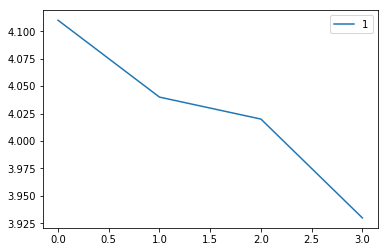

In [36]:
pd.DataFrame([["Step 1 - Number of rounds", 4.11], ["Step 1 - Depth and Min child weight", 4.04], 
              ["Step 2 - Subsample and Colsample", 4.02], ["Step 4 - ETA", 3.93]]).plot(kind="line")

### Saving your model

Although we found the best number of rounds, our model has been trained with more rounds than optimal, thus before using it for predictions, we should retrain it with the good number of rounds. Since we now the exact best num_boost_round, we don't need the early_stopping_round anymore.

In [37]:
num_boost_round = model.best_iteration + 1 # index starts at 0

In [38]:
best_model = xgb.train(params, dtrain, num_boost_round=num_boost_round, evals=[(dtest, "Test")])

[0]	Test-mae:7.69075
[1]	Test-mae:7.62471
[2]	Test-mae:7.55557
[3]	Test-mae:7.48627
[4]	Test-mae:7.41617
[5]	Test-mae:7.34921
[6]	Test-mae:7.28237
[7]	Test-mae:7.21666
[8]	Test-mae:7.15639
[9]	Test-mae:7.09665
[10]	Test-mae:7.03385
[11]	Test-mae:6.97449
[12]	Test-mae:6.91345
[13]	Test-mae:6.85343
[14]	Test-mae:6.79441
[15]	Test-mae:6.73855
[16]	Test-mae:6.68239
[17]	Test-mae:6.62699
[18]	Test-mae:6.57245
[19]	Test-mae:6.52232
[20]	Test-mae:6.47018
[21]	Test-mae:6.42148
[22]	Test-mae:6.37245
[23]	Test-mae:6.32337
[24]	Test-mae:6.27463
[25]	Test-mae:6.22688
[26]	Test-mae:6.18184
[27]	Test-mae:6.13497
[28]	Test-mae:6.09259
[29]	Test-mae:6.04861
[30]	Test-mae:6.00289
[31]	Test-mae:5.95901
[32]	Test-mae:5.91646
[33]	Test-mae:5.87438
[34]	Test-mae:5.83302
[35]	Test-mae:5.79383
[36]	Test-mae:5.75745
[37]	Test-mae:5.71801
[38]	Test-mae:5.67694
[39]	Test-mae:5.63784
[40]	Test-mae:5.60201
[41]	Test-mae:5.56632
[42]	Test-mae:5.52869
[43]	Test-mae:5.49516
[44]	Test-mae:5.46097
[45]	Test-mae:5.4247

All good, now let's use our model to make predictions. We will use the test dataset and compute MAE with the scikit-learn function. We should obtain the same score as promised in the last round of training, let's check!

In [39]:
mean_absolute_error(best_model.predict(dtest), y_test)

3.906106619465919

Great! If you want to re-use your model on new data in the future, it can be a good idea to save it to a file, here is how you can do it with xgboost:

In [40]:
best_model.save_model("my_model.model")

You can then load the model later with:

In [41]:
loaded_model = xgb.Booster()
loaded_model.load_model("my_model.model")

In [42]:
# And use it for predictions.
loaded_model.predict(dtest)

array([3.95622   , 0.33811998, 1.9259537 , ..., 3.821045  , 0.1168783 ,
       3.468561  ], dtype=float32)